
# Float vertical position control, ifremer prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [13]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *


from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

WOA water profile at lon=-50, lat=40


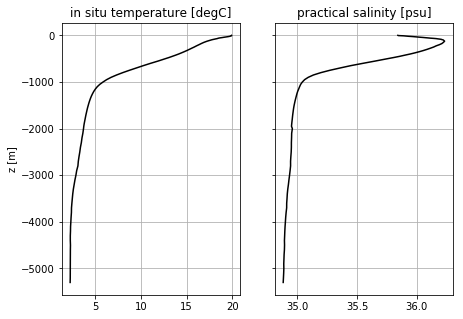

In [14]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [15]:
# Init now active control of the vertical position

#
z=np.arange(-5000.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='IFREMER')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .90

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

1439.4 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 13.07 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte     = 1.03e+09 kg.cm^3   - float constant density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 9.75 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 127.93 cm^3      - present volume addition
  lead  = 100.00 cm        - screw lead
  d_increment  = 0.00 m        - smallest variation of

In [16]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

9.93960815039054
-11.72099235900805


In [17]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
#f.piston.update_d(f.piston.d+.001)
#f.piston_update_vol()
#print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=7.0e-01 cm^3  
z equilibrium = -20.0m


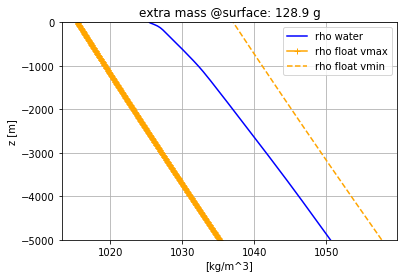

In [18]:
# show densities
plot_float_density(z, f, w)

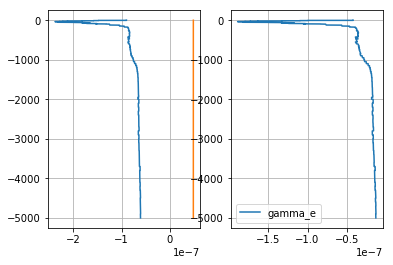

In [19]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

---

## From the surface down to a target level

In [20]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=9.7e-02 m^2/s, fmin/m= -9.2e-02 m^2/s, wmax= 522.9 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 5.8e+02 cm/s, fmin/m= -5.5e+02 cm/s


In [21]:
def plot_kalman(f):
    
    fig = plt.figure(figsize=(15,10))
    #
    ax=fig.add_subplot(231)
    ax.plot(f.log.t,f.log.z,'-', label = "real depth")
    ax.plot(f.t_kalman[1:],-f.log.z_kalman, label ="estimated depth")
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(232)
    ax.plot(f.log.t,f.log.w, label = "real velocity")
    ax.plot(f.t_kalman[1:],-f.log.w_kalman, label ="estimated velocity")
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(233)
    ax.plot(f.log.t,f.log.gammaV, label = "real equivalent compressibility")
    ax.plot(f.t_kalman[1:],f.log.gammaE_kalman, label ="estimated equivalent compressibility")
    ax.set_title("equivalent compressibility as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("gammaE (m^2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(234)
    ax.plot(f.log.t,f.log.Ve, label = "real Ve volume")
    ax.plot(f.t_kalman[1:],f.log.Ve_kalman, label ="estimated Ve volume")
    ax.set_title("volume Ve as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("Ve (m^3)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')   
    #
    ax=fig.add_subplot(235)
    ax.plot(f.log.t,-f.log.dwdt, label = "real acceleration")
    ax.plot(f.t_kalman[1:],f.log.dwdt_kalman, label ="estimated acceleration")
    ax.set_title("acceleration dw/dt as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("dw/dt (m.s^-2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 


    def plot_regulation(f, vmax, nu, tau, delta):
        fig = plt.figure(figsize=(10,5))
        #
        ax=fig.add_subplot(121)
        ax.plot(f.log.t,f.log.z,'-', label = "depth")
        ax.set_title("depth as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
        ax.set_xlabel("t (s)")
        ax.set_ylabel("z (m)")
        ax.grid()
        #
        ax=fig.add_subplot(122)
        ax.plot(f.log.t,f.log.w, label = "velocity")
        ax.set_title("velocity as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
        ax.set_xlabel("t (s)")
        ax.set_ylabel("w (m/s)")
        ax.grid()
        # 
        
def plot_depth(ax,f, vmax, nu, tau, delta):

    ax.plot(f.log.t,f.log.z, label = "vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    #

def plot_velocity(ax,f, vmax, nu, tau, delta):

    ax.plot(f.log.t,f.log.w, label = "vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    # 

---

## Parameter estimation functions for feedback regulation

In [22]:
#Functions and parameters necesary to estimate parameters for feedback regulation

'''
parameters:
    g : gravity acceleration [m.s^-2]
    m : float mass [kg]
    a : float added mass [no dimension]
    r : float radius [m]
    L : float length [m]
    rho_w : water density [kg.m^3]
    omega :  current rotation rate [rad/s]
    lead : screw lead (i.e. displacement after one screw revolution) [m]
    r_piston : piston radius [m]
    u : piston flow [m^3.s^-1]
    translation_max : maximum translation speed for the piston [m.s^-1]
'''

params_ensta = {'r': 0.06, 'L': 0.5, 'a': 1., 'omega_mean' : 20/48*2.*np.pi, 'lead' : 0.00175, 'r_piston' : 0.025,
               'omega_max' : 60./48*2.*np.pi, 'omega_min' : 1/48*2.*np.pi}
params_ensta['m'] = 9.0 #1000. * np.pi * params_ensta['r'] ** 2 * params_ensta['L']

params_ensta['u_mean'] = omega2dvdt(params_ensta['omega_mean'], params_ensta['lead'], params_ensta['r_piston'])
params_ensta['u_min'] = omega2dvdt(params_ensta['omega_min'], params_ensta['lead'], params_ensta['r_piston'])
params_ensta['u_max'] = omega2dvdt(params_ensta['omega_max'], params_ensta['lead'], params_ensta['r_piston'])

params_ifremer = {'r': 0.07, 'L': 0.8278, 'a': 1., 'translation_max': 0.12/5600.*225.,
                  'translation_min' : 0.12/5600.*10., 'lead' : 1.0, 'r_piston' : 0.0195/2,
                 'translation_mean' : 0.12/5600.*100.}

#translation_max = d_increment*(225 pulses par seconde)  (vitesse de translation max en m/s)
#translation_min fixe arbitrairement pour l'instant
        
params_ifremer['m'] = 11.630 #1000. * np.pi * params_ifremer['r'] ** 2 * params_ifremer['L']

params_ifremer['omega_mean'] = params_ifremer['translation_mean']*2.*np.pi/params_ifremer['lead']

params_ifremer['omega_min'] = params_ifremer['translation_min']*2.*np.pi/params_ifremer['lead']

params_ifremer['omega_max'] = params_ifremer['translation_max']*2.*np.pi/params_ifremer['lead']

params_ifremer['u_mean'] = omega2dvdt(params_ifremer['omega_mean'], params_ifremer['lead'], params_ifremer['r_piston'])

params_ifremer['u_min'] = omega2dvdt(params_ifremer['omega_min'], params_ifremer['lead'], params_ifremer['r_piston'])

params_ifremer['u_max'] = omega2dvdt(params_ifremer['omega_max'], params_ifremer['lead'], params_ifremer['r_piston'])

---

## ENSTA float : $\tau$ as a function of $\nu * \pi/2$ for different u


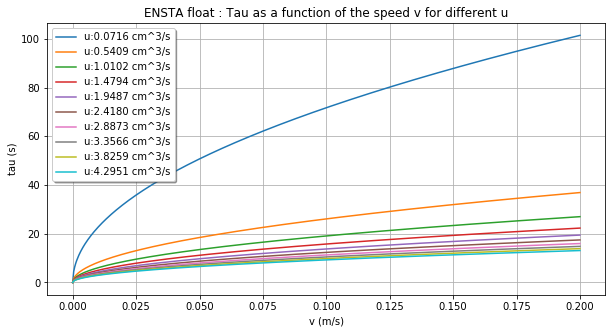

In [23]:
tab_v = np.linspace(0, 0.20, 500)
tab_u = np.linspace(params_ensta['u_min'], params_ensta['u_max'], 10)

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(111)
    
for u in tab_u:
    params_ensta['u'] = u
    tab_tau = tv(tab_v, params_ensta)
    ax1.plot(tab_v, tab_tau, label = "u:%.4f cm^3/s"%(u*1e6))

ax1.set_xlabel("v (m/s)")
ax1.set_ylabel("tau (s)")
ax1.set_title("ENSTA float : Tau as a function of the speed v for different u")
ax1.grid()
legend = ax1.legend(loc='best', shadow=True, fontsize='medium') 

---

## ENSTA float : $\delta$ as a function of $\nu * \pi/2$ for different u


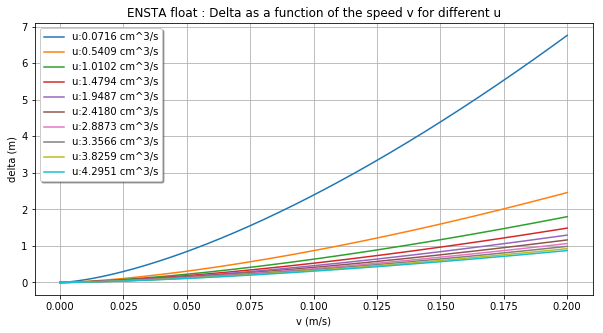

In [24]:
tab_v = np.linspace(0, 0.20, 500)
tab_u = np.linspace(params_ensta['u_min'], params_ensta['u_max'], 10)

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(111)
    
for u in tab_u:
    params_ensta['u'] = u
    tab_delta= zv(tab_v, params_ensta)
    ax1.plot(tab_v, tab_delta, label = "u:%.4f cm^3/s"%(u*1e6))

ax1.set_xlabel("v (m/s)")
ax1.set_ylabel("delta (m)")
ax1.set_title("ENSTA float : Delta as a function of the speed v for different u")
ax1.grid()
legend = ax1.legend(loc='best', shadow=True, fontsize='medium') 

---

## Ifremer float : $\tau$ as a function of $\nu * \pi/2$ for different u


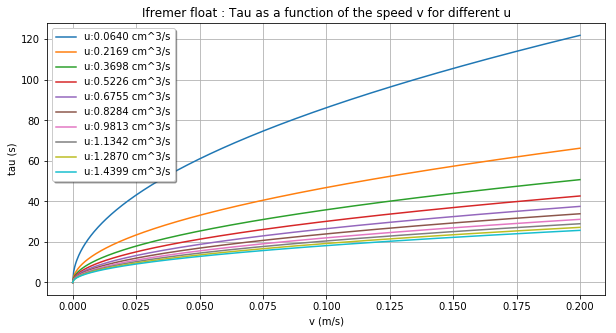

In [25]:
tab_v = np.linspace(0, 0.20, 500)
tab_u = np.linspace(params_ifremer['u_min'], params_ifremer['u_max'], 10)

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(111)
    
for u in tab_u:
    params_ifremer['u'] = u
    tab_tau = tv(tab_v, params_ifremer)
    ax1.plot(tab_v, tab_tau, label = "u:%.4f cm^3/s"%(u*1e6))

ax1.set_xlabel("v (m/s)")
ax1.set_ylabel("tau (s)")
ax1.set_title("Ifremer float : Tau as a function of the speed v for different u")
ax1.grid()
legend = ax1.legend(loc='best', shadow=True, fontsize='medium') 

---

## Ifremer float : $\delta$ as a function of $\nu * \pi/2$ for different u


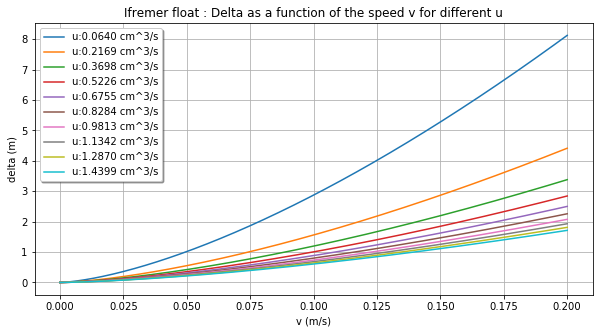

In [26]:
tab_v = np.linspace(0, 0.20, 500)
tab_u = np.linspace(params_ifremer['u_min'], params_ifremer['u_max'], 10)

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(111)
    
for u in tab_u:
    params_ifremer['u'] = u
    tab_delta= zv(tab_v, params_ifremer)
    ax1.plot(tab_v, tab_delta, label = "u:%.4f cm^3/s"%(u*1e6))

ax1.set_xlabel("v (m/s)")
ax1.set_ylabel("delta (m)")
ax1.set_title("Ifremer float : Delta as a function of the speed v for different u")
ax1.grid()
legend = ax1.legend(loc='best', shadow=True, fontsize='medium') 

---

## Feedback regulation without Kalman filter
### Regulation parameters : nu and delta variable, tau fixed

Let's choose $\tau = 1.00 s$

Let's find every pair $(\nu , \delta)$ such that the resulting command $u$ belongs to the interval $[u_{min} , u_{max}]$ where $u_{min}$ and $u_{max}$ are respectively the minimum and the maximum value possible to reach by the command law of the float.

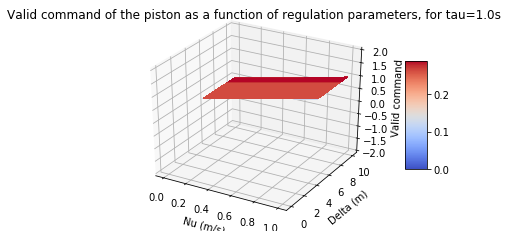

In [32]:
tau = 1.00

nb_points = 1000

VMAX = np.linspace(0.001,0.50,nb_points)

NU = (2/np.pi)*VMAX

DELTA = np.linspace(0.001,10,nb_points)

NU_MESH,DELTA_MESH=np.meshgrid(NU,DELTA)

U_seuil = NU_MESH

z = -20
z_t = -25

forces = 0
#forces = f._f(z, waterp, f.L)
w = 0 #dt_step*_f/(1+f.a)/f.m
dwdt = forces/(1+f.a)/f.m

control = {}
control['tau'] = tau  # Set the root of feed-back regulation # s assesed by simulation
control['nu'] = NU[0] # Set the limit speed : 3cm/s # m.s^-1 assesed by simulation
control['delta'] = DELTA[0] #length scale that defines the zone of influence around the target depth, assesed by simulation
control['gamma'] = f.gamma #mechanical compressibility [1/dbar]
control['L'] = f.L
control['c1'] = f.c1
control['m'] = f.m
control['gammaV'] = f.gammaV
control['rho'] = f.rho_cte
control['a'] = f.a
control['waterp'] = waterp

control['ldb1'] = 2/control['tau'] # /s
control['ldb2'] = 1/control['tau']**2 # /s^2

for i in range(nb_points):
    for j in range(nb_points):
        control.update({'nu':NU_MESH[i,j]})
        control.update({'delta':DELTA_MESH[i,j]})
        u = control_feedback(z, w, dwdt, z_t, control['nu'], control['gammaV'], control['L'], control['c1'],
                         control['m'], control['rho'], control['a'], control['waterp'],
                         control['ldb1'], control['ldb2'], control['delta'])

        if params_ifremer['u_min'] < abs(u) < params_ifremer['u_max']:
            U_seuil[i][j] = 1
        else:
            U_seuil[i][j] = 0

    
fig=plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(NU_MESH, DELTA_MESH, U_seuil, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-2, 2)
ax.set_xlabel("Nu (m/s)")
ax.set_ylabel("Delta (m)")
ax.set_zlabel("Valid command")
ax.set_title("Valid command of the piston as a function of regulation parameters, for tau={}s".format(tau))
#ax.set_xlim(0,0.5)
#ax.set_ylim(0,12)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()




#plt.contourf(NU_MESH, DELTA_MESH, U_seuil, 8, alpha=.75, cmap=cm.hot)
#C = plt.contour(NU_MESH, DELTA_MESH, U_seuil, 8, colors='black', linewidth=.5)
#plt.clabel(C, inline=1, fontsize=10)
#plt.show()



In [13]:
params_ifremer['u_min']

6.39959253496885e-08

In [14]:
params_ifremer['u_max']

1.4399083203679912e-06